<a href="https://colab.research.google.com/github/MaggieLieu/MLiS_examples/blob/master/CNN_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural networks

In this notebook we will be building a convolutional neural network classifier using keras. First you should make sure you are running on GPU:

Runtime > Change runtime type > Hardware accelerator > GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
%matplotlib inline
import matplotlib.pyplot as plt


TensorFlow 2.x selected.


Okay lets download a dataset. In the tensorflow_datasets package we have access to many well known machine learning datasets. See
https://www.tensorflow.org/datasets/catalog/overview
for the full list. Here we will download the MNIST dataset which contains images of handwritten numbers 0-9.

In [0]:
(train_ds, validation_ds, test_ds), metadata = tfds.load('mnist',
split=['train[:80%]', 'train[80%:100%]', 'test'],
with_info=True,
as_supervised=True)

The data are split into test, validation and train sets and we can see how much data is in each. We won't necessarily use all of this data later.



In [4]:
ntrain = len([image[0] for image in train_ds])
nvalid = len([image[0] for image in validation_ds])
ntest = len([image[0] for image in test_ds])

print('Train sample: ', ntrain)
print('Validation sample: ', nvalid)
print('Test sample: ', ntest)

Train sample:  48000
Validation sample:  12000
Test sample:  10000


Let's take the first image from the train dataset and visualise it.

image 1 shape:  (28, 28, 1)


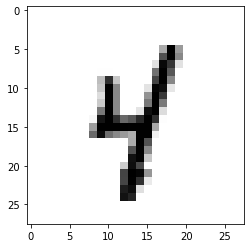

In [5]:
# take 1 image from train and convert to float64 and values 0-1
data1 = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).take(1)

#get first image data and label and plot it
features, labels = iter(data1).next()
print('image 1 shape: ', np.shape(features));
plt.imshow(features[:,:,0], cmap='gray_r');


You should see that we have an 28x28 grayscale image (1 channel) of the handwritten digit 8.

A convolutional neural network consists of convolutional, pooling and fully connected layers. Let's look at these individually.

# Convolution

To give you a feel for what the convolutional layer does, we are now going to apply filters to this image.

Firstly we will apply a horizontal filter

$$\begin{bmatrix}
1 & 1 &  1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix}$$

This filter enhances the horizontal features of the image.

image shape:  (1, 26, 26, 1)


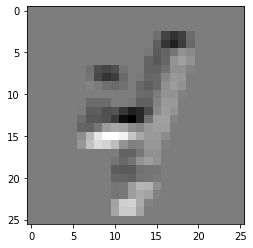

In [6]:
hor_filter = [[1,1,1],[0,0,0],[-1,-1,-1]]

#2D convolution 
output = tf.nn.conv2d(
      input=np.reshape(features, [1,28,28,1]), #batch, height, width, depth
      filters=np.reshape(hor_filter, [3,3,1,1]), #height, width, in_channels, out_channels
      strides=[1,1,1,1], 
      padding="VALID")
print('image shape: ', np.shape(output));
plt.imshow(output[0,:,:,0], cmap='gray');

The filter has extracted the features of horizontal edges in the image. Note that the image size has shrunk from 28x28 to 26x26.

Now lets try a vertical filter
$$\begin{bmatrix}
1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1
\end{bmatrix}$$

You should find that this filter extracts the vertical edges of the image.

image shape:  (1, 26, 26, 1)


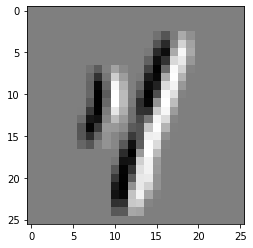

In [7]:
ver_filter = [[1,0,-1],[1,0,-1],[1,0,-1]]

output = tf.nn.conv2d(
      input=np.reshape(features, [1,28,28,1]),
      filters=np.reshape(ver_filter, [3,3,1,1]),
      strides=[1,1,1,1], #in batch, x, y, channel
      padding="VALID")
print('image shape: ', np.shape(output));
plt.imshow(output[0,:,:,0], cmap='gray');

# Pooling

The pooling layer takes shrinks the input image by pooling together pixels. The most common pooling layer is the max pool, which returns the maximum of surrounding pixels. Let's plot what a 3x3 max pool layer does to our image. 

image shape:  (1, 26, 26, 1)


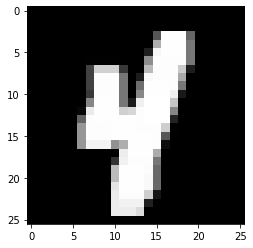

In [8]:
output = tf.nn.max_pool(
      input=np.reshape(features, [1,28,28,1]),
      ksize=3,
      strides=1,
      padding="VALID")
print('image shape: ', np.shape(output));
plt.imshow(output[0,:,:,0], cmap='gray');

Note that if we increase the kernel size to 10, we get even more shrinkage

image shape:  (1, 19, 19, 1)


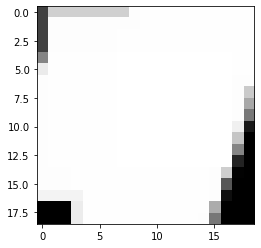

In [9]:
output = tf.nn.max_pool(
      input=np.reshape(features, [1,28,28,1]),
      ksize=10,
      strides=1,
      padding="VALID")
print('image shape: ', np.shape(output));
plt.imshow(output[0,:,:,0], cmap='gray');

# Fully connected

The last important layer is the dense or fully connected layer, which has fully connected neurons. 

Let's set a weight matrix with 1's in the 10th and 11th columns and 0's elsewhere.

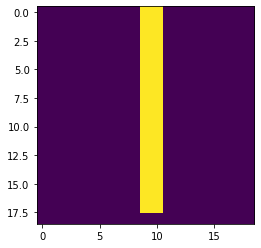

In [21]:
weights = np.zeros([19,19])
weights[0:18,9]=1
weights[0:18,10]=1
plt.imshow(weights)

In [104]:
output2 = np.sum(np.matmul(output[0,:,:,0],weights) + np.zeros(19))
print(output2)

637.262745777145


# CNN model
 First we will take make a training dataset which the models sees and uses to update model parameters, a validation dataset that is not used to update model parameters, but ensures the model is not under/overfit and decide when to stop training, and a test dataset for the final accuracy. These are sampled from the full datasets we made early. 

We apply some augmentation to the training dataset only.

Additionally note thet we use 
shuffle - to shuffle buffer 100 images
batch - split into batches of 24
take - take 1 batch

Note that the order of this is important



In [0]:
train = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).shuffle(100
).batch(24
).take(1)

valid = validation_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).shuffle(100
).batch(24
).take(1)

test = test_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).batch(100
).take(1)

Now we can build our model. Let's make a model with 2 convolutional layers each with 10 3x3 filters, 2 max pool layers with 3x3 filters and 2 fully connected layers

In [0]:
tf.keras.backend.clear_session() #Clear keras session

In [86]:
num_classes = 10
input_shape = [28, 28, 1]

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu', name='conv1',input_shape=input_shape),
  tf.keras.layers.MaxPool2D(pool_size=(3,3), name='pool1'),
  tf.keras.layers.Conv2D(filters=10,kernel_size=(3,3),strides=1,padding='valid',activation='relu', name='conv2'),
  tf.keras.layers.MaxPool2D(pool_size=(3,3), name='pool2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(20, activation='relu',name='dense1'),
  tf.keras.layers.Dense(num_classes, activation='softmax', name='dense2') 
])

model.summary() # print the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 6, 6, 10)          2890      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 2, 2, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 40)                0         
_________________________________________________________________
dense1 (Dense)               (None, 20)                820       
_________________________________________________________________
dense2 (Dense)               (None, 10)                2

In [87]:
LR = 0.001

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(LR),
              metrics=['accuracy'])

history = model.fit(train,
          epochs=500, validation_data=valid)
score = model.evaluate(test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/500
1/1 [==============================] - 0s 446ms/step - loss: 2.3687 - accuracy: 0.0833 - val_loss: 2.3101 - val_accuracy: 0.1667
Epoch 2/500
1/1 [==============================] - 0s 463ms/step - loss: 2.3326 - accuracy: 0.0833 - val_loss: 2.3358 - val_accuracy: 0.0833
Epoch 3/500
1/1 [==============================] - 0s 455ms/step - loss: 2.3251 - accuracy: 0.0000e+00 - val_loss: 2.3370 - val_accuracy: 0.1250
Epoch 4/500
1/1 [==============================] - 0s 482ms/step - loss: 2.3084 - accuracy: 0.0833 - val_loss: 2.2858 - val_accuracy: 0.2917
Epoch 5/500
1/1 [==============================] - 0s 424ms/step - loss: 2.3287 - accuracy: 0.1250 - val_loss: 2.3276 - val_accuracy: 0.0833
Epoch 6/500
1/1 [==============================] - 0s 373ms/step - loss: 2.2981 - accuracy: 0.1250 - val_loss: 2.2846 - val_accuracy: 0.0833
Epoch 7/500
1/1 [==============================] - 0s 412ms/step - loss: 2.2993 - accuracy: 0.0417 - val_loss: 2.2944 - val_accuracy: 0.1667
Epoch 8/5

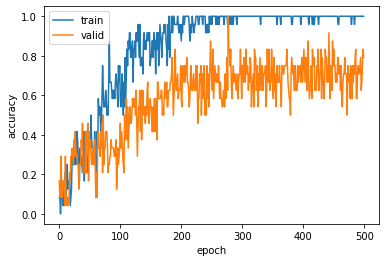

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

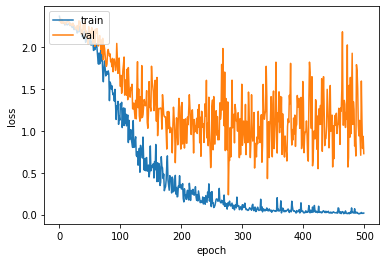

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [100]:
for image, label in test:
  pred = model.predict(image)
  for i in np.arange(100):
    tf.print('predicted: ', np.argmax(pred[i]), ' - truth: ', label[i])

predicted:  3  - truth:  2
predicted:  0  - truth:  0
predicted:  4  - truth:  4
predicted:  8  - truth:  8
predicted:  7  - truth:  7
predicted:  8  - truth:  6
predicted:  0  - truth:  0
predicted:  8  - truth:  6
predicted:  8  - truth:  3
predicted:  1  - truth:  1
predicted:  4  - truth:  8
predicted:  0  - truth:  0
predicted:  7  - truth:  7
predicted:  9  - truth:  9
predicted:  8  - truth:  8
predicted:  8  - truth:  4
predicted:  5  - truth:  5
predicted:  8  - truth:  3
predicted:  4  - truth:  4
predicted:  8  - truth:  0
predicted:  6  - truth:  6
predicted:  6  - truth:  6
predicted:  3  - truth:  3
predicted:  0  - truth:  0
predicted:  2  - truth:  2
predicted:  3  - truth:  3
predicted:  4  - truth:  6
predicted:  6  - truth:  6
predicted:  7  - truth:  7
predicted:  4  - truth:  4
predicted:  9  - truth:  9
predicted:  3  - truth:  3
predicted:  8  - truth:  8
predicted:  9  - truth:  7
predicted:  5  - truth:  5
predicted:  4  - truth:  4
predicted:  3  - truth:  2
p